# Lista 6 - K-médias e PCA

In [36]:
import pandas as pd
import seaborn as sea
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

## Questão 1

Considere o conjunto de dados disponível em quake.csv, organizado em 2 colunas de atributos. Os dados referem-se a latitudes e longitudes de locais em que foram registrados terremotos. Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/772

In [37]:
quake = np.loadtxt(fname='quake.csv', delimiter=',')
quake[:5,:]

array([[-52.26,  28.3 ],
       [ 45.53, 150.93],
       [ 41.85, 142.78],
       [ 29.19, 141.15],
       [-21.66, 169.81]])

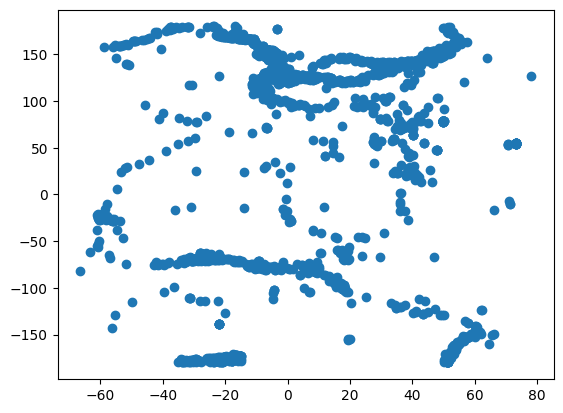

In [38]:
plt.scatter(quake[:, 0], quake[:, 1])
plt.show()

In [39]:
quake_transformado = StandardScaler()

quake_slc = quake_transformado.fit_transform(quake)

* A. Avalie o algoritmo K-médias com distância Euclidiana na tarefa de agrupamento para tais dados. O número de grupos deve ser escolhido entre os valores 4, 5, 6, . . . , 19, 20 a partir do índice DB (Davies-Bouldin). Plote o melhor resultado de agrupamento obtido.
    * Observação: Em cada avaliação repita múltiplas vezes (por exemplo, 20) a execução do algoritmo K-médias, escolhendo a solução com melhor erro de reconstrução.

In [40]:
import warnings

warnings.filterwarnings(action='ignore') # Ignorando error 

In [41]:

dicionario = {'k':[], 'DB':[]}

for i in range(1,21):
    db_melhor = 1e+10
    for j in range(20):
        kmean_ = KMeans( n_clusters=i, n_init=1 )

        pred = kmean_.fit_predict(quake_slc).reshape(-1, 1)

        try:
            score = davies_bouldin_score(quake_slc, pred)
            
            if score < db_melhor:
                db_melhor = score
        except Exception:
            pass
    
    dicionario['k'].append(i)
    dicionario['DB'].append(db_melhor)

In [42]:
results = pd.DataFrame(dicionario)
results

,k,DB
0,1,1.000000e+10
1,2,8.994185e-01
2,3,6.457039e-01
3,4,5.967975e-01
4,5,6.187435e-01
5,6,5.566098e-01
6,7,6.033877e-01
7,8,5.727591e-01
8,9,6.217242e-01
9,10,5.862440e-01


In [43]:
results.iloc[results['DB'].idxmin(),:]

k     12.000000
DB     0.542667
Name: 11, dtype: float64

In [44]:
kmean_ = KMeans( n_clusters=int(results.iloc[results['DB'].idxmin(),:]['k']))

pred = kmean_.fit_predict(quake_slc)

In [45]:
kmean_.cluster_centers_

array([[-0.15548238,  0.52660954],
       [-1.02166388, -1.93103073],
       [ 1.57212759,  0.12358863],
       [ 0.07636918, -1.11282399],
       [-2.12069769, -0.73909408],
       [ 1.48007989, -1.75778818],
       [-1.63410832,  0.77155367],
       [-1.03039652, -1.06312058],
       [ 1.2329599 ,  0.80673251],
       [ 0.61010904,  0.61550536],
       [ 0.93555775, -0.019691  ],
       [-0.56480492,  0.80335523]])

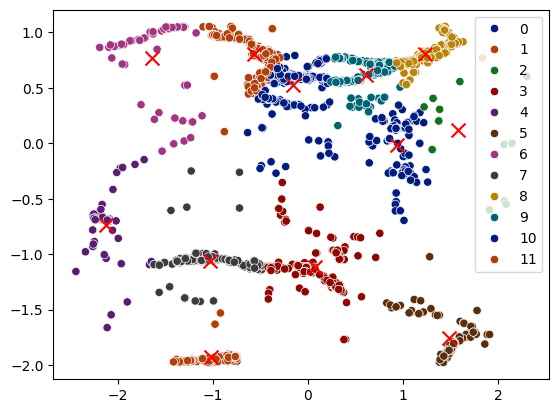

In [46]:
sea.scatterplot(x=quake_slc[:, 0], y=quake_slc[:, 1], hue=pred, palette=sea.color_palette('dark'))
plt.scatter(kmean_.cluster_centers_[:, 0], kmean_.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.show()

b. Repita o item anterior considerando a distância de Mahalanobis

In [47]:
from scipy.spatial.distance import mahalanobis

In [48]:
def kmeans_mahalanobis(X, k, max_iter=100, tol=1e-4, seed=None):
    n_samples, n_features = X.shape
    np.random.seed(seed=seed) # definindo a semente
    
    # Inicialização aleatória
    centroids = X[np.random.choice(n_samples, k, replace=False)]
    covariances = [np.eye(n_features) for _ in range(k)]
    labels = np.zeros(n_samples)

    for _ in range(max_iter):
        distances = np.zeros((n_samples, k))

        for i in range(k):
            inv_cov = np.linalg.inv(covariances[i] + np.eye(n_features) * 1e-6)
            diff = X - centroids[i]

            distances[:, i] = np.sqrt(np.sum((diff @ inv_cov) * diff, axis=1))

        new_labels = np.argmin(distances, axis=1)

        if np.all(labels == new_labels):
            break
        labels = new_labels

        for i in range(k):
            points = X[labels == i]
            if len(points) > 1:
                centroids[i] = points.mean(axis=0)
                covariances[i] = np.cov(points, rowvar=False)
            else:
                # Reinicializa se cluster ficar vazio
                centroids[i] = X[np.random.choice(n_samples)]
                covariances[i] = np.eye(n_features)

    return labels, centroids

In [49]:
dicionario = {'k':[], 'DB':[]}

for i in range(1,21):
    db_melhor = 1e+10
    for j in range(20):
        pred, _ = kmeans_mahalanobis(quake_slc, k=i)

        try:
            score = davies_bouldin_score(quake_slc, pred)
            
            if score < db_melhor:
                db_melhor = score
        except Exception:
            pass
    
    dicionario['k'].append(i)
    dicionario['DB'].append(db_melhor)

In [50]:
results = pd.DataFrame(dicionario)
results

,k,DB
0,1,1.000000e+10
1,2,7.510702e-01
2,3,9.199064e-01
3,4,6.852851e-01
4,5,8.721120e-01
5,6,7.464251e-01
6,7,7.085155e-01
7,8,7.519882e-01
8,9,8.269127e-01
9,10,7.754637e-01


In [51]:
results.iloc[results['DB'].idxmin(), :]

k     4.000000
DB    0.685285
Name: 3, dtype: float64

In [52]:
pred, centroids = kmeans_mahalanobis(quake_slc, k=int(results.iloc[results['DB'].idxmin(), :]['k']))

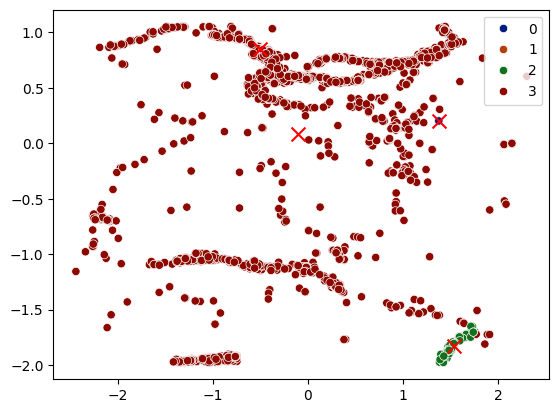

In [53]:
sea.scatterplot(x=quake_slc[:, 0], y=quake_slc[:, 1], hue=pred, palette=sea.color_palette('dark'))
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.show()

------------

# Questão 2

Considere o conjunto de dados disponível em penguins.csv, organizado em 5 colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados referem-se a medições anatômicas de pinguins da Antártida, classificados nas espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

In [54]:
data = np.loadtxt('penguins.csv', delimiter=',')
X = data[:, :4]
y = data[:, 4]

In [55]:
data_transformado = StandardScaler()

data_slc = data_transformado.fit_transform(data)

In [56]:
class pca:
    def __init__(self,components=2):
        self.components = components

    
    def transforma(self, X, y=None):
        X_centro =  X - X.mean(axis=0)
        self.U, self.s, self.Vt = np.linalg.svd(X_centro)
        
        self.components_ = [self.Vt.T[:,i] for i in range(self.components)]
        
        return X_centro.dot(self.Vt.T[:,:self.components])

a. presente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

In [57]:
x_ = pca(2).transforma(X)

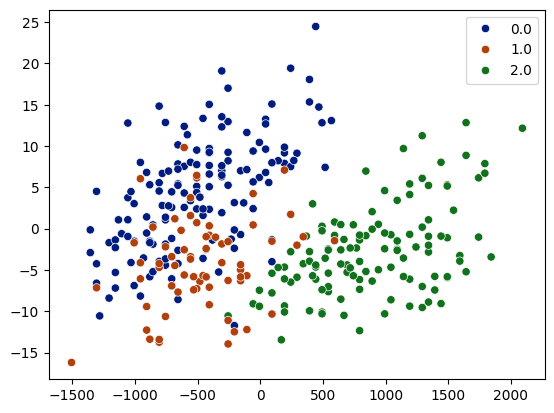

In [58]:
sea.scatterplot(x=x_[:, 0], y=x_[:, 1], hue=y, palette=sea.color_palette('dark'))
plt.show()

b. Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada

In [59]:
for i in [1, 2, 3, 4]:
    pca_ = pca(i)
    pca_.transforma(X)
    variancia= (pca_.s ** 2) / (pca_.s ** 2).sum()
    
    print(f"Componentes: {i}")
    print(variancia[:i]) 
    print(f"Soma acumulada: {variancia[:i].sum():.4f}\n")

Componentes: 1
[0.99989323]
Soma acumulada: 0.9999

Componentes: 2
[9.99893229e-01 7.82232504e-05]
Soma acumulada: 1.0000

Componentes: 3
[9.99893229e-01 7.82232504e-05 2.49073610e-05]
Soma acumulada: 1.0000

Componentes: 4
[9.99893229e-01 7.82232504e-05 2.49073610e-05 3.63992867e-06]
Soma acumulada: 1.0000

